# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip install matplotlib`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [185]:
import math
# importujemy wszystkie potrzebne pakiety

from copy import copy
from math import log, sqrt
from random import betavariate,gauss, normalvariate, random, sample, shuffle, uniform
from bandit_framework import *  # pakiet ze srodowiskiem testowym

In [186]:
# inicjalizujemy parametry testu

arms_number = 50
runs = 50
epochs = 1440
recommendation_size = 10

In [187]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny

arms = {}
for i in range(arms_number):
    activation_probability = uniform(0.01, 0.7)
    mu = uniform(0.1, 2.5)
    sigma = min(uniform(0.1, 1), mu)
    arms['%s' % i] = Arm('%s' % i, activation_probability, lambda: normalvariate(mu, sigma))

arm_ids = list(arms.keys())

In [188]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)

    def recommend(self, size):
        return sample(arm_ids, size)

    def feedback(self, arm_id, payout):
        pass

In [189]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(
                arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in
                                                  sorted(self.expected_payouts.items(), key=lambda x: x[1],
                                                         reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]

    def feedback(self, arm_id, payout):
        pass

    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalexc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [190]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [191]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 16314.82261843701
random: 9652.389734352906


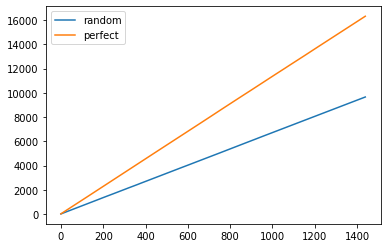

In [192]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 11.288917822334321
random: 7.269075853672095


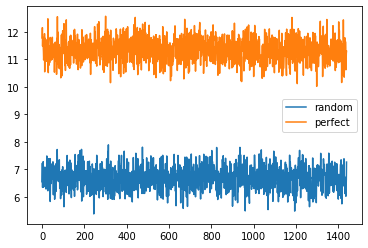

In [193]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [194]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}

    def recommend(self, size):
        top_n_payouts = [x[0] for x in
                         sorted(self.payouts_per_recommendation.items(), key=lambda x: x[1], reverse=True)]

        randomized = copy(self.arm_ids)
        shuffle(randomized)

        recommendation = set()
        idx = 0
        while len(recommendation) < size and idx < len(top_n_payouts):
            recommendation.add(top_n_payouts[idx] if random() > self.epsilon else randomized[idx])
            idx += 1

        for recommended in recommendation:
            self.recommended_rates[recommended] += 1

        return recommendation

    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

In [195]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}

    def recommend(self, size):
        sorted_by_payout_with_optymism_arms = [x[0] for x in sorted(
            self.payouts.items(),
            key=lambda x: x[1] + self.optimism_weight * self._optimism(x[0]),
            reverse=True
        )]

        recommendation = sorted_by_payout_with_optymism_arms[:size]

        for recommended in recommendation:
            self.recommended_rates[recommended] += 1

        return recommendation

    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

    def _optimism(self, arm_id):
        n = max(sum(self.recommended_rates.values()),1)
        n_i = max(self.recommended_rates[arm_id],1)
        return sqrt(2*log(n)/n_i)

In [196]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}

    def recommend(self, size):
        sorted_by_beta_arms = sorted(
            self.arm_ids,
            key= lambda arm_id: betavariate(self.a[arm_id], self.b[arm_id]),
            reverse=True)

        return sorted_by_beta_arms[:size]

    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1 - payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

In [197]:
class GaussianSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, noise_weight):
        super().__init__(bandit_id, arm_ids)
        self.noise_weight = noise_weight
        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}

    def _sample_with_noise(self, arm_id):
        mi = self.recommended_rates[arm_id]
        numerator = gauss(mi,1)
        n = max(sum(self.recommended_rates.values()),1)
        noise = numerator/n
        return noise

    def recommend(self, size):
        sorted_by_gauss_arms = sorted(
            self.arm_ids,
            key=self._sample_with_noise,
            reverse=True)

        return sorted_by_gauss_arms[:size]

    def feedback(self, arm_id, payout):
        self.payouts[arm_id] += payout

In [198]:
import numpy as np


# zaproponuj tutaj swojego wlasnego bandyte

# mozesz np. poszukac w zrodlach algorytmu softmax
# mozesz zaproponowac Gaussian Sampling z parametryzowana funkcja przetwaszajaca impresje (zamiast sqrt)
# mozesz zaproponowac Gaussian Sampling z malejacym odchyleniem standardowym szumu zamiast lub oprocz dzielenia przez impresje
#   (w jaki sposob obliczyc odchylenie standardowe?)
# mozesz zaimplementowac Thompson Sampling oparty o dwoch rozkladach beta
#   albo Thompson-Gaussian Sampling, z rozkladem beta i normalnym
# mozesz tez zaproponowac cos calkowicie innego - byle tylko twoj algorytm wpisywal sie we framework testowy


class Softmax(Bandit):
    def __init__(self, bandit_id, arm_ids, exploring_weight):
        super().__init__(bandit_id, arm_ids)
        self.exploring_weight = exploring_weight
        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids} #counts
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids} #values, mean of payouts
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}

    def _arms_probability(self):
        p = [self.payouts[i] for i in self.arm_ids]
        t = self.exploring_weight
        e = np.exp([x/t for x in p])
        return e/e.sum()

    def recommend(self, size):
        probability = self._arms_probability()
        return np.random.choice(self.arm_ids, size, p = probability)

    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        n = max(sum(self.recommended_rates.values()),1) #num of steps
        old_payout = self.payouts[arm_id]
        new_payout = ((n-1)*old_payout + payout) * 1/n
        self.payouts[arm_id] = new_payout



## Część 3. - porównanie bandytów

In [199]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in [(1, 1), (10, 1), (1, 10), (10, 10)]])
bandits.extend([GaussianSampling('gs_%s' % noise_weight, arm_ids, noise_weight) for noise_weight in [0.1, 0.25, 0.5, 0.75, 1]])
# pamietaj, by dodac swojego bandyte
bandits.extend([Softmax('sm_%s' % exploring_weight, arm_ids, exploring_weight) for exploring_weight in [0.1, 0.25, 0.5, 0.75, 1]])


In [200]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_10_1
Simulating: ts_1_10
Simulating: ts_10_10
Simulating: gs_0.1
Simulating: gs_0.25
Simulating: gs_0.5
Simulating: gs_0.75
Simulating: gs_1
Simulating: sm_0.1
Simulating: sm_0.25
Simulating: sm_0.5
Simulating: sm_0.75
Simulating: sm_1



Aggregated results:

perfect: 16346.595033219483
ts_1_10: 16329.563055558494
ts_1_1: 16289.02847816027
ts_10_1: 16269.620674449174
egreedy_0.01: 16155.852873292224
egreedy_0.05: 15955.874931739474
ts_10_10: 15896.071937973096
egreedy_0.1: 15611.152864386204
ucb_10: 15267.332481889483
egreedy_0.25: 14529.260588582783
ucb_1: 13254.650188338292
ucb_0.1: 13150.751590051112
ucb_0.01: 13065.642573940579
sm_0.1: 12859.333097599303
sm_0.25: 12843.533554181671
sm_0.5: 11969.28607852775
sm_0.75: 11355.356488165036
sm_1: 10976.356555900658
gs_0.75: 9650.676643835342
gs_0.25: 9645.836720972069
gs_0.5: 9637.425703135325
random: 9634.191419737508
gs_0.1: 9626.637371118002
gs_1: 9601.74670903705


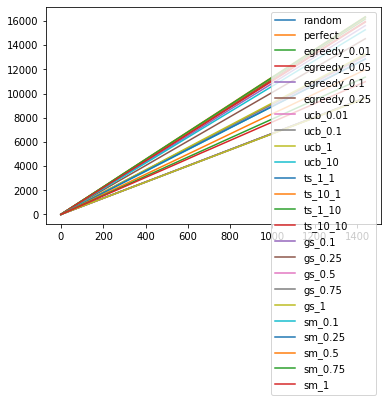

In [201]:
runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

ts_10_10: 11.40772356750319
ts_10_1: 11.398749612781199
ts_1_1: 11.393301606205956
ts_1_10: 11.366660651428539
perfect: 11.142852898197157
egreedy_0.01: 10.943671830726611
egreedy_0.1: 10.849269282538211
egreedy_0.05: 10.515815515877406
ucb_10: 10.39099938481862
egreedy_0.25: 9.851602840656318
ucb_1: 9.49089029535949
ucb_0.01: 9.409850288876905
sm_0.1: 9.404146242314647
ucb_0.1: 8.92938392494862
sm_0.25: 8.717076316146528
sm_0.5: 8.133871347956022
sm_1: 7.596404929098116
gs_0.5: 7.468603215847377
sm_0.75: 7.375730261773186
gs_0.75: 6.769039910785048
gs_0.1: 6.717739459483961
random: 6.595756218570683
gs_1: 6.552106151046543
gs_0.25: 6.464173707533821


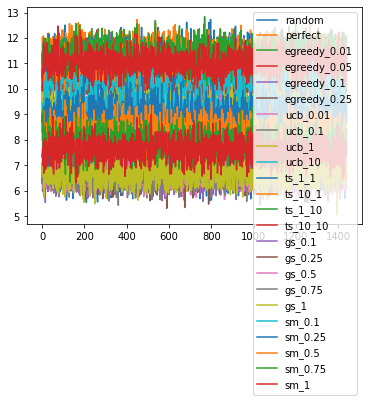

In [202]:
runner.plot_results(results, runs, epochs, mode='average')